# **Pneumonia Diagnosis Using Chest X-rays**
## This project aims to develop a deep learning model for diagnosing pneumonia from lung X-ray images.

In [ ]:
!pip install tensorflow

In [ ]:
!pip install kaggle

In [ ]:
!pip install scikeras

## **Environment Setup**
### This cell imports all the necessary libraries required for data manipulation, image processing, and progress tracking. These libraries will be used throughout the project for preprocessing the dataset, analyzing the data, and building the model.

In [ ]:
# Importing libraries for data manipulation
import pandas as pd  # To handle and analyze tabular data (e.g., loading CSV files with image labels)

# Importing libraries for image processing
import cv2                                 # To load, process, and transform images (e.g., resizing, grayscale conversion)
import numpy as np                         # To handle numerical computations and arrays (e.g., image pixel values)
import scipy                               # For advanced mathematical operations and image manipulation
import skimage                             # For additional image processing tasks (e.g., resizing, filtering)
from skimage.transform import resize       # To resize images to a consistent shape for the model

# Importing libraries for file handling and dataset organization
import os                                  # To interact with the file system (e.g., traversing directories, managing file paths)
from random import shuffle                 # To shuffle the dataset entries for unbiased training

# Importing library for progress tracking
from tqdm import tqdm                      # To display progress bars during time-consuming tasks like data preprocessing

# Import necessary libraries for plotting and image manipulation
import matplotlib.pyplot as plt
import seaborn as sns

## **Download Dataset**
#### This cell downloads the Chest X-Ray Pneumonia dataset from Kaggle using the Kaggle API.

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:10<00:00, 209MB/s]
100% 2.29G/2.29G [00:10<00:00, 234MB/s]


### **Unzip Dataset**
#### This cell extracts the contents of the downloaded `.zip` file into the `/content/chest_xray` directory.

In [ ]:
!unzip chest-xray-pneumonia.zip -d /content/chest_xray

Streaming output truncated to the last 5000 lines.
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: /content/chest_xray/chest_xray/train/NORMAL/IM-0442-0001.jpeg  


## **Explore the Dataset**
### This step helps us to understand the structure of the dataset. We'll first check the contents of the unzipped dataset folder.

In [ ]:
# List the files in the 'chest_xray' directory to check the folder structure
print(os.listdir('/content/chest_xray/chest_xray/chest_xray'))

['test', 'val', 'train', '.DS_Store']


### **Check Directory Structure for Train,Test, & Validation Folders**
### We will check the structure of the train, test, and validation directories to ensure they contain the expected subfolders for the classes.

In [ ]:
# Define the paths to the train, test, and validation directories
train_dir = '/content/chest_xray/chest_xray/chest_xray/train'
test_dir  = '/content/chest_xray/chest_xray/chest_xray/test'
val_dir   = '/content/chest_xray/chest_xray/chest_xray/val'

In [ ]:
# Check the directory structure for train, test, and validation directories
print("Train directory structure:", os.listdir(train_dir))        # List subfolders in the train directory
print("Test directory structure:", os.listdir(test_dir))          # List subfolders in the test directory
print("Validation directory structure:", os.listdir(val_dir))     # List subfolders in the validation directory

Train directory structure: ['NORMAL', 'PNEUMONIA', '.DS_Store']
Test directory structure: ['NORMAL', 'PNEUMONIA', '.DS_Store']
Validation directory structure: ['NORMAL', 'PNEUMONIA', '.DS_Store']


### **Check the Number of Images in Each Folder**
### Now that we have confirmed the directory structure, we will check how many images are available in each of the `train`, `test`, and `val` directories. This helps us ensure that the dataset is properly organized.

In [ ]:
# Function to count images in the subfolders (NORMAL, PNEUMONIA) inside a given directory
def count_images_in_subfolders(directory):
    image_extensions = ['.jpeg', '.jpg', '.png']
    # Initialize image count
    image_count = 0
    # Loop through the subfolders (NORMAL, PNEUMONIA) and count image files
    for subfolder in os.listdir(directory):
        subfolder_path = os.path.join(directory, subfolder)
        if os.path.isdir(subfolder_path):  # Check if it's a folder
            # Count image files in the subfolder
            image_count += len([f for f in os.listdir(subfolder_path) if any(f.endswith(ext) for ext in image_extensions)])

    return image_count

# Count images in train, test, and validation directories
train_images_count = count_images_in_subfolders(train_dir)
test_images_count = count_images_in_subfolders(test_dir)
val_images_count = count_images_in_subfolders(val_dir)

# Print the number of images in each directory
print(f"Train images: {train_images_count}")
print(f"Test images: {test_images_count}")
print(f"Validation images: {val_images_count}")

Train images: 5216
Test images: 624
Validation images: 16


## **Preprocessing**

### **Get Labels for Subfolders**
### In this step, we will define a function `get_label()` that will iterate through the directory containing the subfolders `NORMAL` and `PNEUMONIA`. Based on the subfolder name, we will assign a label (0 for NORMAL and 1 for PNEUMONIA). This will help us prepare the label information for image classification.


In [ ]:
def get_label(directory):
  # Initialize an empty list to store labels
  labels = []

  # Iterate through all the directories in the main directory (Dir)
  for nextdir in os.listdir(directory):
      if not nextdir.startswith('.'):     # Skip hidden files like .DS_Store
          label = None                    # Initialize a variable to hold the label value

          # If the subfolder is "NORMAL", assign label 0
          if nextdir == 'NORMAL':
              label = 0
          # If the subfolder is "PNEUMONIA", assign label 1
          elif nextdir == 'PNEUMONIA':
              label = 1

          # Only append valid labels to the list
          if label is not None:
              labels.append((nextdir, label))    # Save the subfolder name and its label

  # Return the list of (subfolder name, label) pairs
  return labels

### Preprocess Images and Create Datasets
### Now, we will define a function `preprocessing_data()` to preprocess the images. This function will:
#### 1. Call the `get_label()` function to get the labels for the subfolders (`NORMAL` and `PNEUMONIA`).
#### 2. Loop through the images inside each subfolder and resize each image to the shape `(150, 150)`.
### 3. Append the image data to the `X` list (features) and the corresponding label to the `y` list (targets).
### Finally, it will return `X` and `y` as numpy arrays.

In [ ]:
def preprocessing_data(directory):

  X = []  # Initialize an empty list to store image data
  y = []  # Initialize an empty list to store labels

  # Get the labels for each subfolder (NORMAL, PNEUMONIA)
  labels = get_label(directory)

  # Loop through the labels and the corresponding subfolder names
  for nextdir, label in labels:
      temp = os.path.join(directory, nextdir)  # Construct the path to the subfolder

      # Loop through all images inside the subfolder
      for image_filename in tqdm(os.listdir(temp)):
          path = os.path.join(temp, image_filename)  # Full path to the image
          img = cv2.imread(path, cv2.IMREAD_COLOR)  # Read the image in color (3 channels)

          if img is not None:  # Check if the image was read successfully
              img = skimage.transform.resize(img, (150, 150))  # Resize image to 150x150 pixels
              img = np.asarray(img)  # Convert the image to a numpy array

              # Append the image data and label to their respective lists
              X.append(img)
              y.append(label)

  # Convert the lists to numpy arrays for further processing
  X = np.asarray(X)
  y = np.asarray(y)

  # Return the processed image data and labels
  return X, y

### **Loading Training Data**
### This step processes the training data. The `preprocessing_data` function reads all images from the `train_dir`, resizes them to 150x150, assigns labels to each image based on the folder structure (`NORMAL` = 0, `PNEUMONIA` = 1), and returns the processed images (`X_train`) along with their corresponding labels (`y_train`).

In [ ]:
# Preprocess and load training data
X_train, y_train = preprocessing_data(train_dir)

100%|██████████| 3876/3876 [11:10<00:00,  5.78it/s]


### **Loading Testing Data**
### This step processes the testing data. The `preprocessing_data` function reads all images from the `test_dir`, resizes them to 150x150, assigns labels to each image based on the folder structure, and returns the processed images (`X_test`) along with their corresponding labels (`y_test`).

In [ ]:
# Preprocess and load testing data
X_test, y_test = preprocessing_data(test_dir)

100%|██████████| 390/390 [00:48<00:00,  8.08it/s]


### **Loading Validation Data**
### This step processes the validation data. The `preprocessing_data` function reads all images from the `val_dir`, resizes them to 150x150, assigns labels to each image based on the folder structure, and returns the processed images (`X_val`) along with their corresponding labels (`y_val`).

### **Verify the Shapes of Training and Testing Data**
#### This step ensures that the training and testing data were preprocessed correctly. We will check:
- The shape of the training images (`X_train`) and testing images (`X_test`).
- The shape of the training labels (`y_train`) and testing labels (`y_test`).
This step helps verify the correctness of the data before moving on to label encoding.

In [ ]:
print("Data Shape:")
print("Training Data Shape (X_train):", X_train.shape)
print("Testing Data Shape (X_test):", X_test.shape)

print("--------------------------------------------------")

print("Label Shape:")
print("Training Labels Shape (y_train):", y_train.shape)
print("Testing Labels Shape (y_test):", y_test.shape)

Data Shape:
Training Data Shape (X_train): (5216, 150, 150, 3)
Testing Data Shape (X_test): (624, 150, 150, 3)
--------------------------------------------------
Label Shape:
Training Labels Shape (y_train): (5216,)
Testing Labels Shape (y_test): (624,)


### **One-Hot Encode the Labels**
#### Deep learning models require target labels to be in a one-hot encoded format for classification tasks.
#### We use `to_categorical` from Keras to convert the numeric labels (`y_train`, `y_test`) into binary matrices representing the classes:
- `NORMAL` → `[1, 0]`
- `PNEUMONIA` → `[0, 1]`

In [ ]:
# Import the utility function to convert class labels into one-hot encoded vectors
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 2)  # One-hot encode training labels
y_test = to_categorical(y_test, 2)   # One-hot encode testing labels

### The arrays have already been one-hot encoded, so there's no need for further transformation. The pixel values of the images are not normalized in this step, as they are already in the required format for training.

### **Verify the Shapes After One-Hot Encoding**
#### After applying one-hot encoding, we check the shapes of the encoded labels:
- The additional dimension corresponds to the number of classes (2 in this case: `NORMAL` and `PNEUMONIA`).

#### This step ensures that the labels are now correctly formatted for training the model.


In [ ]:
print("One-Hot Encoded Training Labels Shape (y_train):", y_train.shape)
print("One-Hot Encoded Testing Labels Shape (y_test):", y_test.shape)

One-Hot Encoded Training Labels Shape (y_train): (5216, 2)
One-Hot Encoded Testing Labels Shape (y_test): (624, 2)


## **Visualizing Normal vs Pneumonia X-rays**

#### Load the filenames of images from the "PNEUMONIA" and "NORMAL" folders in the training directory. These filenames will be used to retrieve and visualize the images.

In [ ]:
# Load filenames of Pneumonia images from the training directory
Pimages = os.listdir(os.path.join(train_dir, "PNEUMONIA"))

# Load filenames of Normal images from the training directory
Nimages = os.listdir(os.path.join(train_dir, "NORMAL"))

#### We define a plotter function to display side-by-side comparisons of a "NORMAL" chest X-ray and a "PNEUMONIA" chest X-ray. The images are resized to 150x150 pixels for consistency with the preprocessing step.

In [ ]:
# Define a function to plot side-by-side comparisons of NORMAL and PNEUMONIA images
def plotter(i):

  # Read a Pneumonia image and resize it to 150x150 pixels
  imagep1_path = os.path.join(train_dir, "PNEUMONIA", Pimages[i])  # Construct full path
  imagep1 = cv2.imread(imagep1_path)
  imagep1 = skimage.transform.resize(imagep1, (150, 150, 3), mode='reflect')

  # Read a Normal image and resize it to 150x150 pixels
  imagen1_path = os.path.join(train_dir, "NORMAL", Nimages[i])  # Construct full path
  imagen1 = cv2.imread(imagen1_path)
  imagen1 = skimage.transform.resize(imagen1, (150, 150, 3))

  # Concatenate the Normal and Pneumonia images side-by-side
  pair = np.concatenate((imagen1, imagep1), axis=1)

  # Print a description for the comparison
  print("(Left) - No Pneumonia Vs (Right) - Pneumonia")
  print("-----------------------------------------------------------------------------------------------------------------------------------")

  # Plot the concatenated image pair
  plt.figure(figsize=(10, 5))
  plt.imshow(pair)  # Display the image
  plt.axis('off')   # Hide axes for better visualization
  plt.show()        # Show the plot

#### Uses the plotter function to visualize the first five pairs of "NORMAL" and "PNEUMONIA" X-rays. This step helps in understanding the differences between the two classes visually.

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


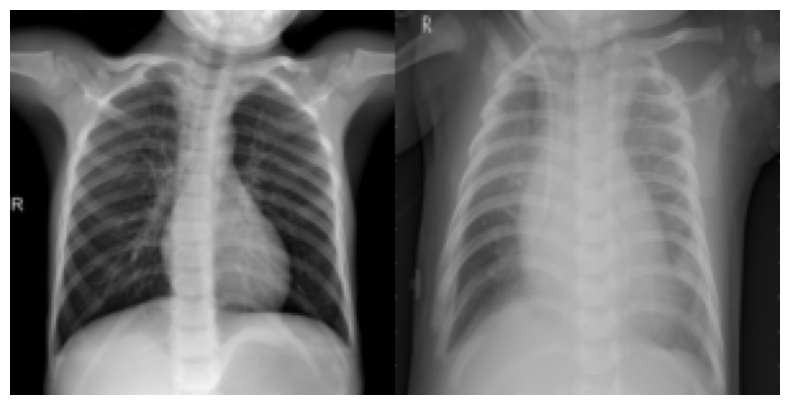

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


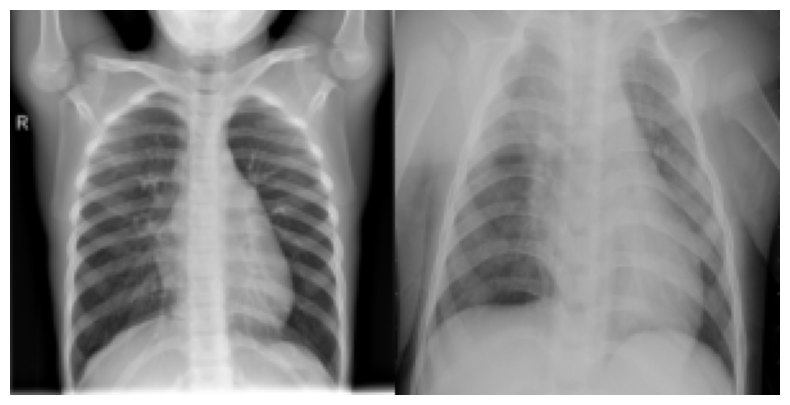

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


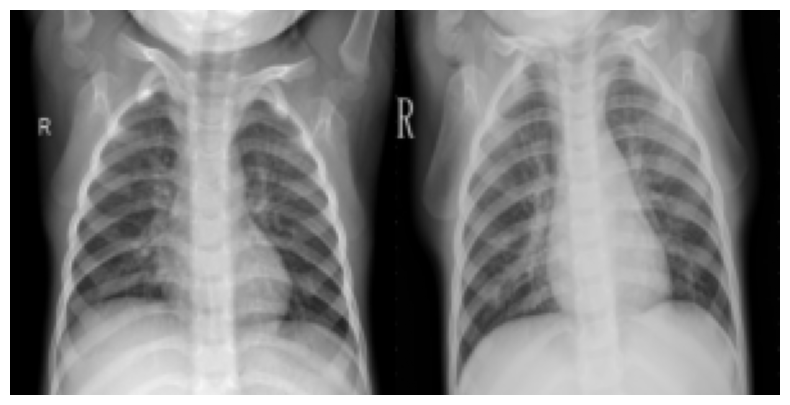

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


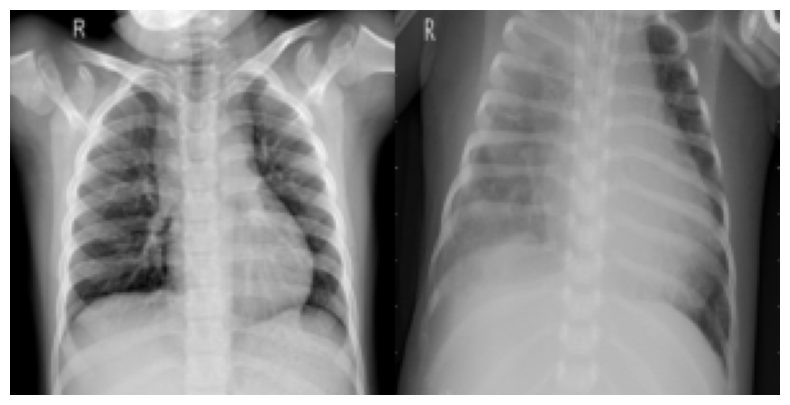

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


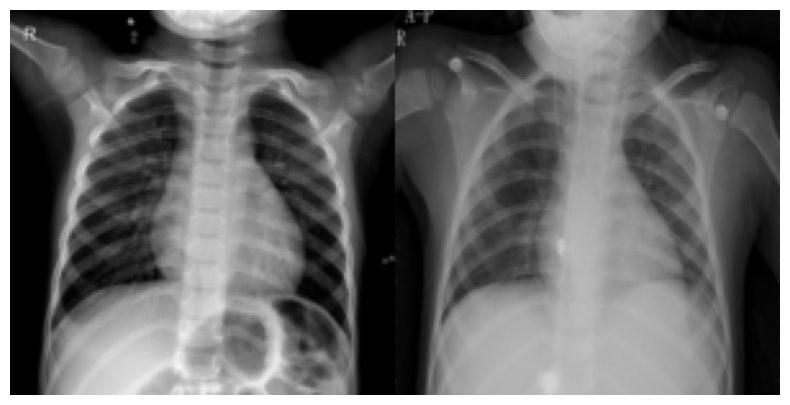

In [ ]:
# Loop through the first five image indices and display side-by-side comparisons
for i in range(0, 5):
    plotter(i)  # Call the plotter function to display each pair of images

### **Class Distribution Visualization**  
#### This code calculates the total count of each class from the one-hot encoded training labels (`y_train`) and visualizes the class distribution using a bar plot.  
- **X-Axis**: Displays class names ('Normal', 'Pneumonia').  
- **Y-Axis**: Shows the number of instances for each class.  
- **Title**: "Class Distribution in Training Data" provides context for the visualization.  

#### This plot helps to easily understand the balance between the classes in the training data.


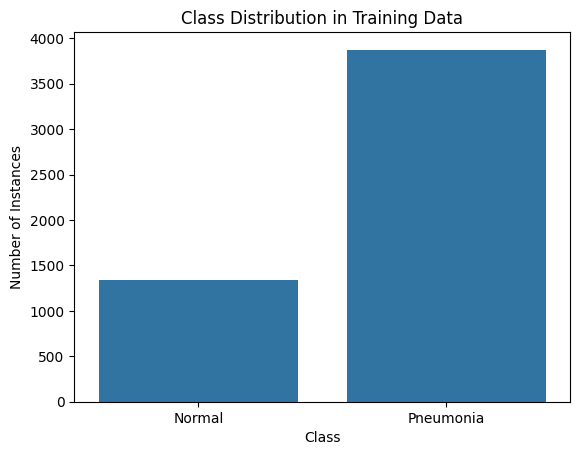

In [ ]:
# Calculate the sum of one-hot encoded labels to determine class counts
count = y_train.sum(axis=0)

# Create a count plot to visualize the class distribution
sns.barplot(x=['Normal', 'Pneumonia'], y=count)

plt.xlabel('Class')                                 # Label for x-axis
plt.ylabel('Number of Instances')                   # Label for y-axis
plt.title('Class Distribution in Training Data')    # Add a title

plt.show()

### The classes are imbalanced, so validation accuracy alone won't accurately reflect model performance. Metrics like precision, recall, and the confusion matrix should also be considered for a comprehensive evaluation.

## **Configuring Training Callbacks**

## **Learning Rate Reduction**
#### The ReduceLROnPlateau callback, which helps to adjust the learning rate during model training. If the validation accuracy (val_acc) stops improving for a specified number of epochs (patience), the learning rate is reduced by a factor of 0.1. This is particularly useful for fine-tuning the model and avoiding overfitting or convergence to suboptimal points.

In [ ]:
# Import necessary callback functions
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# Initialize a callback to reduce the learning rate when the validation accuracy plateaus
lr_reduce = ReduceLROnPlateau(
    monitor='val_accuracy',   # Metric to monitor (validation accuracy)
    factor=0.1,               # Factor by which to reduce the learning rate
    epsilon=0.0001,           # Minimum change in monitored value to qualify as an improvement
    patience=3,               # Number of epochs with no improvement before reducing the learning rate
    verbose=1                 # Verbosity mode (1 = update messages)
)


### **Model Checkpoint**
#### The ModelCheckpoint callback to save the model's weights during training. The weights are saved only when the validation accuracy (val_acc) reaches its highest value. This ensures that the best-performing model is preserved, preventing the loss of optimal weights due to overfitting or other issues.

In [ ]:
# Initialize the ModelCheckpoint callback to save the best model
checkpoint = ModelCheckpoint(
    'best_model.keras',               # save the model weights
    monitor='val_accuracy',        # Metric to monitor (validation accuracy)
    verbose=1,                     # Verbosity mode (1 = update messages)
    save_best_only=True,           # Save weights only if the monitored metric improves
    mode='max'                     # Save weights when validation accuracy is maximized
)

### **Early Stopping** :
### Stops training when the validation loss stops improving, helping to avoid overfitting and saving time by halting unnecessary epochs. It also restores the model weights from the epoch with the best validation loss.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping  # Import EarlyStopping in the current cell

# Define EarlyStopping to stop training when validation loss stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',          # Monitor the validation loss to determine stopping
    patience=3,                  # Wait for 3 epochs without improvement before stopping
    restore_best_weights=True    # After stopping, restore the model weights from the epoch with the best validation loss
)

## **Import Libraries for Model Building and Optimization**
#### In this step, we import essential libraries and modules for constructing a deep learning model using Keras and performing hyperparameter optimization with Scikit-learn. These imports enable the creation of a convolutional neural network (CNN), customization of its layers, and optimization of its parameters to enhance model performance.

In [ ]:
# Import necessary libraries for building a Sequential model
from tensorflow.keras.models import Sequential               # For creating a linear stack of layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D     # For convolutional, pooling
from tensorflow.keras.layers import Dense, Activation        # For adding fully connected layers and activation functions
from tensorflow.keras.layers import Dropout                  # For regularization to prevent overfitting
from tensorflow.keras.layers import Flatten                  # For flattening the input to feed into dense layers
from tensorflow.keras.constraints import MaxNorm             # For applying constraints on weights
from tensorflow.keras.regularizers import l2

# Import optimizers for compiling the model
from tensorflow.keras.optimizers import SGD, RMSprop, Adam         # Stochastic Gradient Descent and RMSprop optimizers

# Import convolutional and pooling layers for CNN
from tensorflow.keras.layers import Conv2D, BatchNormalization            # For preprocessing data like one-hot encoding
from tensorflow.keras import backend as K                                 # For backend-specific operations

# Import necessary callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


# Import image augmentation module
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import libraries for hyperparameter optimization
from sklearn.model_selection import GridSearchCV             # For performing grid search on hyperparameters
from scikeras.wrappers import KerasClassifier                # For wrapping Keras model to work with Scikit-learn

## **Reshaping Training and Testing Data for the Model**
#### In this step, we reshape the training and testing data to match the expected input shape of the convolutional neural network (CNN). The CNN expects input data with dimensions corresponding to the number of samples, the number of channels (e.g., 3 for RGB images), and the image dimensions (150x150 pixels in this case). Therefore, the reshaping step will ensure that the data is in the correct format before being fed into the model.

In [ ]:
# Reshape the training data to have shape (number of samples, channels, height, width)
X_train = X_train.reshape(5216, 3, 150, 150)                   # 5216 images, 3 channels (RGB), 150x150 pixels

# Reshape the testing data to have shape (number of samples, channels, height, width)
X_test = X_test.reshape(624, 3, 150, 150)                     # 624 images, 3 channels (RGB), 150x150 pixels

In [ ]:
y_train = np.argmax(y_train, axis=1)  # Convert (batch_size, 2) -> (batch_size, 1)
y_test = np.argmax(y_test, axis=1)

## **CNN Model for Pneumonia Detection with Custom Activation**
#### This cell constructs a Convolutional Neural Network (CNN) model designed to classify images into two categories: pneumonia and normal. The model utilizes several convolutional layers with varying depths, dilations, and pooling operations, followed by a custom Swish activation function for the fully connected layers. The output layer uses a sigmoid function for binary classification.

## **Data Augmentation**
### In this cell. we apply a series of random transformations to the training images. These transformations include rotation, shifting, zooming, and flipping. The goal is to artificially increase the size and diversity of the training dataset, which helps improve the model's ability to generalize to new, unseen images. The fit() method calculates the necessary statistics from the training data for normalization during augmentation. This technique helps reduce overfitting and improves model performance.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Apply to training data
datagen.fit(X_train)

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1495: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (5216, 3, 150, 150) (150 channels).
  warnings.warn(


In [ ]:
# Define a custom swish activation function
def swish_activation(x):
  return (K.sigmoid(x) * x)                      # Swish activation function: x * sigmoid(x)

# Build the CNN model
model = Sequential()                             # Initialize Sequential model

# First convolutional block
model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(3, 150, 150), kernel_regularizer=l2(0.01)))     # 1st Conv layer
model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))                                                             # 2nd Conv layer
model.add(MaxPooling2D(pool_size=(2, 2)))                                                # Max Pooling layer to reduce spatial dimensions

# Second convolutional block
model.add(Conv2D(32, (3, 3), activation='relu', padding="same", kernel_regularizer=l2(0.01)))                # 3rd Conv layer
model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))                                             # 4th Conv layer
model.add(MaxPooling2D(pool_size=(1, 1)))                                                # Max Pooling layer

# Third convolutional block
model.add(Conv2D(64, (3, 3), activation='relu', padding="same", kernel_regularizer=l2(0.01)))                # 5th Conv layer
model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))                                             # 6th Conv layer
model.add(MaxPooling2D(pool_size=(1, 1)))                                                # Max Pooling layer

# Fourth convolutional block with dilated convolutions
model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same", kernel_regularizer=l2(0.01)))          # 7th Conv layer
model.add(Conv2D(96, (3, 3), padding="same", activation='relu'))                                                              # 8th Conv layer
model.add(MaxPooling2D(pool_size=(1, 1)))                                               # Max Pooling layer

# Fifth convolutional block with dilated convolutions
model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same", kernel_regularizer=l2(0.01)))         # 9th Conv layer
model.add(Conv2D(128, (3, 3), padding="same", activation='relu'))                                                            # 10th Conv layer
model.add(MaxPooling2D(pool_size=(1, 1)))                                               # Max Pooling layer

# Global average pooling to reduce dimensions safely
#model.add(GlobalAveragePooling2D())  # Reduces feature map to 1x1 per channel

# Flatten the output before passing to dense layers
model.add(Flatten())                                             # Flatten layer

# Dropout layer for regularization
model.add(Dropout(0.5))

# Add a dense layer with custom swish activation
model.add(Dense(64, activation=swish_activation))                # Fully connected layer with swish activation


# Output layer for binary classification (Pneumonia vs Normal)
model.add(Dense(1, activation='sigmoid'))                        # Output layer with sigmoid activation for binary classification


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## **Compiling the CNN Model for Training**

In [ ]:
# Compile the model
model.compile(loss='binary_crossentropy',                      # Loss function for binary classification
              optimizer=Adam(learning_rate=0.00005),                    # Optimizer with a small learning rate
              metrics=['accuracy'])                            # Metric to evaluate model performance

### **Displaying the Model Summary**

In [ ]:
# Print the summary of the model architecture
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 3, 150, 16)          │          21,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 3, 150, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 1, 75, 16)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 1, 75, 32)           │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 1, 75, 32)           │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 1, 75, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 1, 75, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 1, 75, 64)           │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 1, 75, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 1, 75, 96)           │          55,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 1, 75, 96)           │          83,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 1, 75, 96)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 1, 75, 128)          │         110,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 1, 75, 128)          │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 1, 75, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 9600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         614,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,104,513 (4.21 MB)

 Trainable params: 1,104,513 (4.21 MB)

 Non-trainable params: 0 (0.00 B)

None


## **Training the Model**

In [ ]:
# Define batch size and number of epochs for training
batch_size = 32                                      # Set the number of samples per gradient update
epochs = 6                                            # Set the number of complete passes through the training dataset

In [ ]:
# Train the model using the training data and validate it on the test data
history = model.fit(X_train, y_train,                         # Training data and labels
                    validation_data=(X_test, y_test),         # Test data for validation during training
                    callbacks=[early_stopping, lr_reduce, checkpoint],        # Callbacks for learning rate reduction and saving best model
                    epochs=epochs)                            # Number of epochs to train the model for

Epoch 1/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.7335 - loss: 3.1852
Epoch 1: val_accuracy improved from -inf to 0.62500, saving model to best_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 65s 368ms/step - accuracy: 0.7335 - loss: 3.1837 - val_accuracy: 0.6250 - val_loss: 2.6220 - learning_rate: 5.0000e-05
Epoch 2/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.7487 - loss: 2.3115
Epoch 2: val_accuracy improved from 0.62500 to 0.78205, saving model to best_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 378ms/step - accuracy: 0.7488 - loss: 2.3103 - val_accuracy: 0.7821 - val_loss: 1.9081 - learning_rate: 5.0000e-05
Epoch 3/6
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.8803 - loss: 1.5863
Epoch 3: val_accuracy improved from 0.78205 to 0.85096, saving model to best_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 79s 362ms/step - accuracy: 0.8803 - loss: 1.5857 - val_accuracy: 0.8510 - val_loss: 1.3861 - learning_rate: 5.0000e-05
Epoch 4/6
163/163 ━━━━━━━━━━━━━

## **Save Model**

In [ ]:
# Save the best model in HDF5 format
model.save('final_model.keras')

In [ ]:
from tensorflow.keras.models import load_model

# Load the best model later
best_model = load_model('best_model.keras', custom_objects={'swish_activation': swish_activation})

## **Visualization of Training and Validation Metrics**
#### This cell visualizes the model's training process by plotting accuracy and loss for both the training and validation datasets over epochs. These plots help evaluate how well the model is learning and generalizing, indicating if further improvements or adjustments are needed.

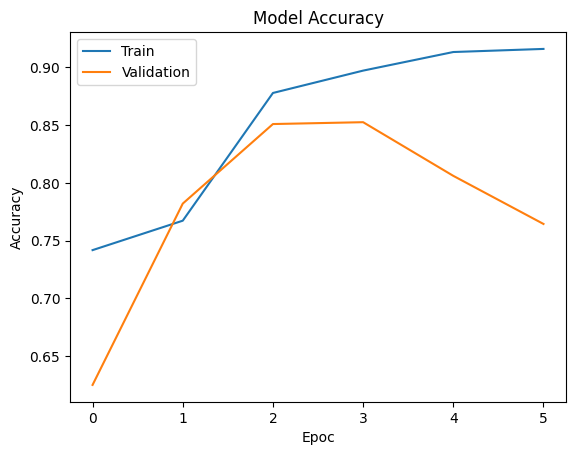

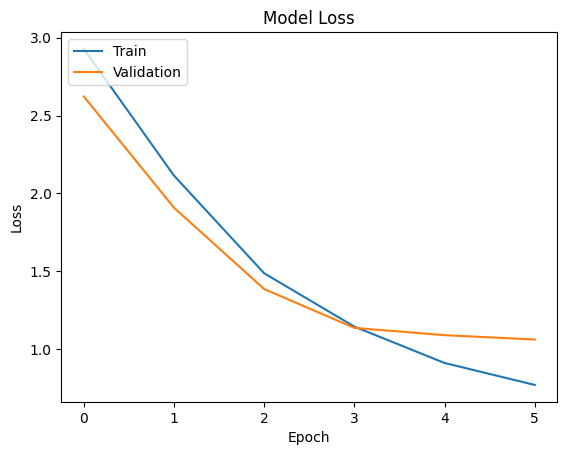

In [ ]:
# Plot training and validation accuracy

plt.plot(history.history['accuracy'])            # plot training accuracy over epochs
plt.plot(history.history['val_accuracy'])        # Plot validation accuracy over epochs

plt.title('Model Accuracy')                 # Add title to the plot
plt.ylabel('Accuracy')                      # label for the y-axis
plt.xlabel('Epoc')                          # label for the x-axis

plt.legend(['Train', 'Validation'], loc='upper left')       # Add a legend to distinguish lines

# Display the plot
plt.show()


#  Plot training and validation loss

plt.plot(history.history['loss'])           # Plot training loss over epochs
plt.plot(history.history['val_loss'])       # Plot validation loss over epochs

plt.title('Model Loss')                     # Add a title to the plot
plt.ylabel('Loss')                          # Label for the y-axis
plt.xlabel('Epoch')                         # Label for the x-axis

plt.legend(['Train', 'Validation'], loc='upper left')            # Add a legend to distinguish lines

# Display the plot
plt.show()

### The graphs show the training and validation performance of the model over epochs. The Model Loss graph indicates a steady decrease in both training and validation loss, suggesting that the model is effectively learning and improving its predictions while maintaining good generalization. Similarly, the Model Accuracy graph shows an increasing trend for both training and validation accuracy, indicating the model's ability to correctly learn patterns from the data. The minimal gap between training and validation metrics in both graphs highlights that the model is not overfitting and is performing consistently on unseen data.